# 全连接神经网络
## 目录
<font size=4>一.[课程摘要](#abstract)</font>

<font size=4>二.[加载library](#library)</font>

<font size=4>三.[加载数据集](#dataset)</font>

<font size=4>四.[使用逻辑回归分类](#logistic)</font>

<font size=4>五.[隐藏层](#hiddenlayer)</font>

<font size=4>六.[含有隐藏层的全连接神经网络](#fullyconnected)</font>

<font size=4>七.[使用PyTroch构建全连接神经网络进行非线性分类](#pytorch)</font>

<font size=4>八.[拓展和延伸](#extra)</font>

<font size=4>九.[总结](#summary)</font>

# 一.课程摘要
<span id="abstract"></span>

本次课程通过构建一个具有一层隐藏层的**全连接神经网络**，对一个“花瓣”形状的非线性可分数据集进行分类。

<span id="library"></span>
# 二.加载library

首先我们导入本课程代码所需要的`python`库：

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn
from sklearn.metrics import accuracy_score
from torch import nn, optim
import torch.nn.functional as F
import torch
import torch.utils.data as data
from util.planar_utils import sigmoid, load_planar_dataset, load_extra_datasets
from util.planar_utils import plot_decision_boundary as boundary
from IPython.display import Image
%matplotlib inline


np.random.seed(1)  # 设置随机数的种子以使每次运行的结果恒定

<span id="dataset"></span>
# 三.加载数据集

现有数据集中包含400个红色或蓝色点的信息，每种颜色的点各200个。本课程我们会根据数据点的颜色和位置进行分析训练，并尝试比线性分类更加复杂的分类方式。

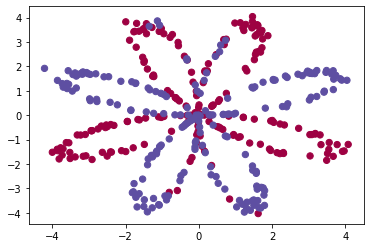

In [2]:
# 加载数据集
X, Y = load_planar_dataset()
features = X.T
label = Y.T
# 查看数据集的大致形状
plt.scatter(X[0, :], X[1, :], c=Y.flatten(), s=40, cmap=plt.cm.Spectral)

可以观察到，数据集呈现出“花瓣”形状，花瓣有蓝色和红色两种颜色，每种颜色各4瓣。接下来我们来查看一下数据集中每个数据点的具体结构，请你补全代码：

In [3]:
########################## Question 1 ##########################
'''
    要求：
    现有400个样本存储在数据集中，
    请读取并展示第100个样本，以了解每个数据的特征结构。
    使用 print(展示内容) 函数输出结果
    
    提示：
    features是数据集的特征集，是一个[2x400]的二维数组，其中每一行代表一个样本
    label是数据集的标签，是一个[1x400]的二维数组
    可以通过"数组名[行数][列数]"来访问数组的元素，例如features[2][1]
    数组的下标是从0开始的。例如访问数组第3行第一个元素，则这个元素的索引为：数组名[2][0]
    你需要展示两个特征和一个标签
'''
##################### Start For Your Code #####################
print('\n展示其中一个数据')
print(features[99])
#####################  End For Your Code  #####################



展示其中一个数据
[ 1.96360773 -0.2387049 ]


参考输出：
```python
展示其中一个数据
1.9636077277772677
-0.23870489920658625
0
```

可以看到，数据集为二维点集，每个点的位置用二维坐标（$x_1，x_2$）表示，每个点的颜色用标签$y$表示，其中$y=0$为红色，$y=1$为蓝色。你找到第100个点在图中的位置了吗？

接下来的任务就是对这些不同颜色的点进行分类，理想的分类效果是根据颜色和位置分成几类，看起来就像是将每一片“花瓣”分开。

<span id="logistic"></span>
# 四.使用逻辑回归进行分类

使用`sklearn`中的逻辑回归工具构建一个简单的`逻辑回归(logistic regression)`模型，然后对数据集进行分类，并且打印出分类边界值和准确率。

**`sklearn`介绍**

`Scikit-learn(sklearn)`是机器学习中常用的第三方模块，我们在前面的课程中已经接触过。该模块对常用的机器学习方法进行了封装，包括回归(Regression)、降维(Dimensionality Reduction)、分类(Classfication)、聚类(Clustering)等方法，帮助快速进行模型构建和模型训练。

Sklearn具有以下特点：

- 简单高效的数据挖掘和数据分析工具
- 让每个人能够在复杂环境中重复使用
- 建立在NumPy、Scipy、MatPlotLib之上

In [4]:
# 训练逻辑回归模型
# 调用scikit-learn的Logistic回归算法类库进行训练，交叉验证参数cv=5
clf = sklearn.linear_model.LogisticRegressionCV(cv=5)
Y2 = Y.flatten()
clf.fit(X.T, Y2.T)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

逻辑回归的准确率为: 47% 


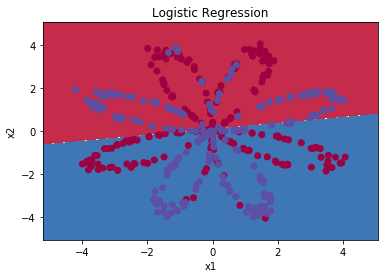

In [5]:
# 输出分类边界
boundary(lambda x: clf.predict(x), X, Y.ravel())
plt.title("Logistic Regression")

# 输出准确率
LR_predictions = clf.predict(X.T)
accuracy = (np.dot(Y, LR_predictions) + np.dot(1-Y, 1-LR_predictions))/float(Y.size)
print('逻辑回归的准确率为: %d%% ' % (accuracy * 100))

可以看到分类结果不理想，模型准确率只有47%。因为简单的逻辑回归适用于线性分类的情况，而我们使用的数据集无法被线性二分。为了解决非线性分类问题，我们使用含有隐藏层的全连接神经网络改进模型，增强非线性分类能力。

<span id="hiddenlayer"></span>
# 五.隐藏层

## 1.从单层神经网络到多层神经网络

下图1展示的是一个**单层神经网络**示意图。在这个神经网络中，每个圆圈代表一个神经元。单层神经网络的计算过程为：

> 输入->加权求和->非线性函数映射->输出

由于输入神经元和输出神经元直接相连，故称作单层神经网络。

**多层神经网络**由单层神经网络演变而来，如下图2所示。不同于单层神经网络的直连模式，多层神经网络中输入神经元和输出神经元经过几层中间的神经元间接相连，图2中的神经网络，相比图1中的单层神经网络，增加了 $a1,a2,a3,a4$ 神经元组成的一层中间层。从输入层到中间层以及从中间层到输出层，均进行一次加权求和和非线性函数映射，从而增强了网络非线性分类的能力。

多层神经网络的每一层与单层神经网络的计算过程相同。

神经网络除输入层和输出层以外的中间层均被称作**隐藏层**。

<img src="./src/p5.png" style="width:500px;"><img src="./src/p6.png" style="width:400px;">

## 2.隐藏层定义

神经网络除**输入层**和**输出层**外的**中间层**。

## 3.为什么增加隐藏层可以提高分类效果 ?


- 单一神经元只有一个线性函数加一个非线性函数，而隐藏层为输入和输出之间增加了一个或多个线性函数加非线性函数的组合，从而提高了其对非线性数据的分类效果。


- 数学意义——坐标变换，将空间的“维度”和“方向”进行扭曲，增强了非线性分类的能力。


- 模型意义——从底层特征（例如像素）获得更高层的“特征”（亮度、色彩分布等），从而提高了分类的准确率。


## 4.隐藏层激活函数——tanh

**tanh** 函数是一种常用的隐藏层激活函数。

### (1)定义

$tanh$ 是双曲函数中的一个，$tanh()$ 为双曲正切。在数学中，双曲正切 $tanh$ 是由基本双曲函数双曲正弦和双曲余弦推导而来。

\begin{equation*}
tanhx=\frac{sinhx}{coshx}=\frac{e^x−e^{−x}}{e^x+e^{−x}}
\end{equation*}
$tanh$ 和 $sigmoid$ 函数的图像如下：
<img src="./src/tahn&sigmoid.png" style="width:600px;">
在隐藏层，$tanh$ 函数要优于 $sigmoid$ 函数，可以认为是 $sigmoid$ 的平移版本，优势在于其取值范围介于 $(-1, 1)$ 之间，数据的平均值为 0 ，而不像 $sigmoid$ 函数平均值为 0.5，有类似数据中心化的效果。

但在输出层，$sigmoid$ 函数也许会优于 $tanh$ 函数，原因在于你希望输出结果的概率落在 [0，1] 之间，比如二元分类，$sigmoid$ 更适合作为输出层的激活函数。

### (2)拓展内容—— $tanh$ 求导

$tanh$ 函数定义为: 
\begin{equation*}
y =\frac{e^x−e^{−x}}{e^x+e^{−x}}
\end{equation*}
<br>与此相关的基础求导公式：
\begin{equation*}
\frac{u}{v}' = \frac{u' v - uv'}{v^2}
\end{equation*}
<br>同样应用链式法则，其求导过程为：

\begin{equation*}
\begin{split}
\frac{dy}{dx} &= \frac{ (e^x - e^{-x})' * (e^x + e^{-x}) - (e^x - e^{-x}) * (e^x + e^{-x})' } {(ex + e^{-x})^2} \\\\
&=  \frac{(e^x - (-1) * e^{-x}) * (e^x + e^{-x}) - (e^x - e^{-x}) * (e^x + (-1) * e^{-x})}{ (e^x + e^{-x})2} 　　\\\\
&=  \frac{ (e^x + e^{-x})^2  -  (e^x - e^{-x})^2 )}{  (e^x + e^{-x})^2} \\\\
&=  1 -  \frac{(e^x - e^{-x})}{(e^x + e^{-x})^2} \\\\
&= 1 - y^2 
\end{split}
\end{equation*}


了解激活函数的求导公式，在反向传播中就知道了如何进行梯度下降。

<span id="fullyconnected"></span>
# 六.含有隐藏层的全连接神经网络

## 1."全连接"含义

在一个多层神经网络中，对第 $n-1$ 层和 $n$ 层而言：

$n-1$ 层的任意一个节点，都和第 $n$ 层所有节点有连接。即第 $n$ 层的每个节点在进行计算的时候，激活函数的输入是 $n-1$ 层所有节点的加权。故称此网络为**全连接神经网络**。

例如在图2中，输入层的每一个节点均与隐藏层的4个节点连接；隐藏层的每一个节点均与输出层的2个节点连接：

<img src="./src/p6.png" style="width:400px;">

全连接是一种不错的模式，但是网络很大的时候，训练速度会很慢。可通过**部分连接**改进网络的性能。部分连接就是人为的切断两层部分节点直接的连接，这样训练时计算量大大减小。

<span id="fenxi"></span>
## 2."花瓣"数据集分类的全连接网络分析

### (1)拓展内容——反向传播

**概念**

- 神经网络通过优化算法来逐步完善模型，而优化就是一个不断计算**梯度**并调整网络中可学习参数的过程。

- 在网络的训练过程中，梯度计算分为两个步骤：**正向传播**与**反向传播**。

- 正向传播会根据搭建的网络结构，将输入单元的状态传递到输出单元产生输出结果。输出值可能与实际值存在偏差，故利用误差进行反向传播。

- 反向传播借助链式求导法则 ，计算两个或两个以上复合函数的导数，将输出单元的梯度反向传播回输入单元，并根据计算出的梯度，调整网络的参数。

**示例**
<img src="./src/p7.png" style="width:300px;">

我们为一个二次函数表达式构建出一个神经网络，如上图所示。设二次函数的方程为 $y=w_1x^2+w_2x+b$，则网络中 $input_1=x^2, input_2=x$，$out(即y')$ 为输出层的输出结果$out=w_1input1+w_2input_2$ 。网络具有2个权重 $w_1$ 和 $w_2$。假设真实的权重 $w_1=3, w_2=2$，即二次函数方程为 $y=3x^2+2x+1$，而网络初始化权重 $w_1=5,w_2=1$，即我们猜测的二次函数方程为 $y'=5x^2+x+1$。现在有自变量 $x=2$，对应输入值$input_1=4,input_2=2$ 。训练网络过程如下：

**Step1. 正向传播**（输入层→输出层）
  
  输入 $input_1=4,input_2=2$，经过神经网络得到输出 $out=23$.
  

**Step2. 反向传播**（输出层→输入层）

1. 计算总误差

   使用 **方差（square error）**作为误差公式：
   
   $$E=(out-target)^2=(y'-y)^2=36$$
   
2. 链式求导

   以权重参数 $w_1$ 为例，如果我们想知道 $w_1$ 对整体误差产生了多少影响，可以用整体误差对 $w_1$ 求偏导求出：（链式法则）
   
   $$\frac{∂E}{∂w_1}=\frac{∂E}{∂out}·\frac{∂out}{∂w_1}$$
   
   $$\frac{∂E}{∂out}=2(out-target)=2(y'-y)=12$$
   
   $$\frac{∂out}{∂w_1}=input_1=4$$
   
   故：
   
   $$\frac{∂E}{∂w_1}=48$$

3. 更新权值

   $$w_1^+=w_1-η·\frac{∂E}{∂w_1}$$
   
   其中 $η$ 为学习率，用来控制每次更新的幅度，这里我们取 0.03，则：
   
   $$w_1^+=5-2.4=3.56$$

   同理可以得到反向传播后的 $w_2^+=0.28$。这样反向传播就完成了。
   

经过反向传播后的神经网络对于输入值 $input_1=4,input_2=2$ 的预测结果为 $y'=15.8$，与真实值的误差较之前减小。

### (2)神经网络示意图

我们按照需要搭建一个含有1层隐藏层的全连接神经网络：

<img src="./src/classification_kiank.png" style="width:600px;height:350px;">

在这个神经网络中，每个圆圈代表一个神经元。

网络由**输入层(input layer)**、**隐藏层(hidden layer)**、**输出层(output layer)组成**。输入层和输出层的大小分别为 2 和 1 ，对应点二维坐标的输入和一个在 [0,1] 之间的概率输出，若输出 $y≥0.5$ 则标记为 1（蓝色），$y<0.5$ 则标记为 0（红色）。

隐藏层的大小可以根据需求设定，上图中的隐藏层大小为 4。

隐藏层的激活函数为 $tanh$，输出层的激活函数为 $sigmoid$。

### (3)计算原理

当我们从输入层向神经网络输入点的坐标时，我们通过将坐标“展开”为一列神经元来可视化网络，如下图左半部分所示（数据是几维的，这一列就有几个神经元。以本课数据为例的话，这一列将只包含$x_1,x_2$两个神经元。)：

<img src="./src/neuron.png" style="width:600px;height=380px;">

下面计算过程的符号含义如下：

|         符号         |                             含义                             |
| :------------------: | :----------------------------------------------------------: |
|     $z_i^{[j]}$      | $z$表示一个神经元，其中$i$代表神经元是该层第$i$个神经元，$j$表示第$j$个隐藏层 |
|     $a_i^{[j]}$      | $a$表示一个神经元，$i,j$标与$z_i^{[j]}$中一致，并且$a$由$z$添加激活函数计算出，$a=f(z)$，$f$为激活函数 |
|        $x_i$         |  $x$表示输入神经元，为样本的特征值，$i$表示样本第$i$个特征   |
| $\omega_{i,k}^{[j]}$ | 权重，$i,j$与$a_i^{[j]}$中一致，$k$表示该权重是上一层$k$个神经元的权重 |
|     $b_i^{[j]}$      | 偏移量，$i,j$与$a_i^{[j]}$中一致，加入$b$以使$z$的图像可以进行平移，而不一定总是经过原点 |
|       $\hat y$       |                        输出神经元的值                        |
|      $y_{预测}$      |                     输出神经元对应的标签                     |




假设我们考察神经网络第一层到第二层之间的连接，让我们集中注意力到第一个输出神经元的连接，我们将这个神经元标记为 $z_1^{[1]}$，其中上标 "[1]" 代表该神经元与网络第一层的神经元连接，下标 "1" 代表这是该层的第一个神经元。并将每个输入神经元和相应的权重标记为 $x_i$ 和 $w_i$,其中 $i$ 代表第 i 个输入神经元。

那么此图右边的权重公式为：

$$z_1^{[1]} = w_{1,1}^{[1]}x_1 + w_{1,2}^{[1]}x_2 +...+w_{1,n}^{[1]}x_{n}+ b_1^{[1]} $$

其中 $w$ 为权重，下标 $n$ 为输入层神经元的个数，$b$ 为偏移量，加入$b$以使公式的图像可以进行平移，而不一定总是经过原点。


<br>神经元 $z_1^{[1]}$ 表示上一层相连接节点的加权和，与上一层神经元之间为线性关系，我们希望神经网络实现非线性分类，则需要通过非线性函数将 $z_1^{[1]}$ 变换为 $a_1^{[1]}$ 。再次查看我们设计的网络，那么如何从 $z_1^{[1]}$ 得到 $a_1^{[1]}$ 呢？

结合“网络示意图”中的神经元设计，我们知道，我们设定隐藏层的激活函数为 $tanh$，那么通过权重公式传入下一层的 $z$ 还需要添加激活函数才能变为 $a$，则有:

$$a_1^{[1]} = \text{tanh}(z_1^{[1]}) $$

以此类推，输入层到隐藏层的任意神经元的变换公式为（由于输入层只有2个神经元，$x$ 的下标只到 $x_2$)：

$$z_i^{[1]} = w_{i1}^{[1]}x_1 + w_{i2}^{[1]}x_2 + b_i^{[1]} $$
<br>
$$a_i^{[1]} = \text{tanh}(z_i^{[1]}) $$

<br>然后将所有的 $w,z,a$ 和 $x$ 以矩阵 $\boldsymbol W,\boldsymbol z,\boldsymbol a$ 和 $\boldsymbol x$ 形式存储,则有：
$$\boldsymbol z^{[1] } =  \boldsymbol W^{[1]} \boldsymbol x+ b^{[1] }$$ 
<br>$$\boldsymbol a^{[1] } = \tanh(\boldsymbol z^{[1] })$$

那么同理，由于输出层的激活函数是 $sigmoid$ 函数(σ)，隐藏层到输出层的任意神经元变换公式为：

$$\boldsymbol z^{[2]} = \boldsymbol W^{[2]} \boldsymbol a^{[1]} +\boldsymbol b^{[2]}$$
<br>$$\boldsymbol a^{[2] } = \sigma(\boldsymbol z^{ [2] })$$
<br>$$\hat{y} =\boldsymbol a^{[2] }$$
对于输出层 $\hat{y}$，我们进行标签预测:
$$y_{预测} = \begin{cases} 1 & \mbox{if } 0.5 ≤ \hat y ≤ 1  \\ 0 & \mbox 0 ≤ \hat y< 0.5 \end{cases}$$
<br>到这里实现了对一个点的分类。

<br>最后与数据集的标签相比，我们计算代价函数:

在多分类问题中，我们使用交叉熵代价函数作为代价函数。多分类任务的交叉熵代价函数定义为：

$$Loss=-log(p_c)$$

其中 $p=[p_0,..,p_{c-1}]$是向量，$p_c$ 表示样本预测为第c类的概率。

如果是二分类任务的话，因为只有正例和负例，且两者的概率和是1，所以不需要预测一个向量，只需要预测一个概率就好了，代价函数定义简化如下：

$$Loss=-(y·log(\hat y)+(1-y)·log(1-\hat y))$$

其中 $\hat y$ 是模型预测样本是正例的概率，$y$ 是样本标签，如果样本属于正例，取值为1，否则取值为0。

假设我们的训练集有m个样本，则全连接神经网络的代价函数为：

$$Loss = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small $$

代价函数为所有样本代价函数的平均值，其中$i$表示数据集中第$i$个样本。

### (4)复习——模型训练的一般流程

1. 数据预处理


2. 将数据输入神经网络（每个神经元先输入值加权累加再输入激活函数作为该神经元的输出值）正向传播，得到预测结果


3. 将预测结果输入误差函数（loss function），与真实值值比较得到误差，通过误差判断识别程度（损失值越小越好）


4. 通过反向传播（反向求导，误差函数和神经网络中每个激活函数都要求，最终目的是使误差最小）来确定梯度


5. 最后通过梯度来调整每一个权值，以减小预测值与真实值之间误差


6. 重复上述过程直到设定次数或误差损失的平均值不再下降

<span id="pytorch"></span>
# 七.使用PyTroch构建全连接神经网络进行非线性分类

## 1.PyTroch 简介

`PyTorch`是一个深度学习框架，旨在实现简单灵活的实验。它有以下特点:

- 类似于`NumPy`，但是它可以使用GPU。

- 可以用它定义深度学习模型，可以灵活地进行深度学习模型的训练和使用。

自 2017 年初首次推出,`PyTorch`很快成为 AI 研究人员的热门选择并受到推崇。`PyTorch`有许多优势，如采用 Python 语言、动态图机制、网络构建灵活以及拥有强大的社群等。由于其灵活、动态的编程环境和用户友好的界面，`PyTorch`是快速实验的理想选择。

学习链接:

> pytorch官网：<https://pytorch.org/>
<br>pytorch英文官方文档（网页版）：<https://pytorch.org/docs/stable/index.html>
<br>pytorch中文官方文档（网页版）：<https://pytorch-cn.readthedocs.io/zh/latest/>
<br>pytorch中文官方深度学习教程（英文pdf版，11月刚出的书)：
>>代码下载：<https://www.manning.com/downloads/1754>
<br>书籍链接：<https://pan.baidu.com/s/1C1PODfpqJcxrhrLXoFrLUQ>
密码:yomw

<font color='red'>代码理解有困难的话建议观看这个视频快速入门https://www.bilibili.com/video/av54777178</font>

## 2.加载数据集

对数据集并对其做相应的转换，以便后续划分训练集和测试集。

In [6]:
'''
导入数据类型：
X：
type:ndarray
shape:(400,2)
output:
[[x1,x2,x3...],[y1,y2,y3...]] 其中yi为纵坐标

Y:
type:ndarray
shape:(1,400)
output:
[[y1,y2,y3...]] 其中yi为标签，0红色，1蓝色
'''
'''
目标数据类型：
X:
type:ndarray
shape:(2,400)
output:
[[x1,y1],[x2,y2],[x3,y3]...]

Y:
type:ndarray
shape:(400,)为一维行向量
output:
[y1,y2,y3...]
'''

# 对X转置，对Y降维，以符合pytorch框架数据格式
X = X.transpose()
Y = Y.ravel()
#print(X.shape)
#print(Y.shape)
# print(X)
# print(Y)
# X，Y为数据样本特征和标签集，由于转置的原因，切记这个代码块执行奇数次，如果不确定，输出矩阵的维数检查是否和目标数据类型一致

## 3.构建训练集

使用`pytorch`的`dataset`类构建数据集类，然后使用`Dataloader`类数据集进行批量读取。其中`dataset`类需要重写`__getitem__`函数获取每一个数据和`__len__`函数获取数据集的数据个数。

In [7]:
# 首先要继承torch.utils.data.Dataset类，完成点及标签的读取。


class my_dataset(data.Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        # pytorh的训练集必须是tensor形式，可以直接在dataset类中转换，省去了定义transform
        # 转换Y数据类型为长整型
        self.point = torch.from_numpy(x).type(torch.FloatTensor)
        self.label = torch.from_numpy(y).type(torch.FloatTensor)
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x = self.point[index]
        label = self.label[index]
        # print(x)
        return x, label

    def __len__(self):
        return len(self.label)

# 然后定义训练集的transform函数，将数组转换成torch tensor


加载训练集和验证集，请你补全代码：

In [8]:
########################## Question 2 ##########################
'''
要求：
加载训练集，每次读取20个点，并且打乱顺序，防止一次读取的全是红色点或蓝色点
加载验证集，每次读取全部400个点，并且打乱顺序

提示：
pytorch 定义了数据集后需要将训练集和验证集按照批次导入进行训练，所以需要使用Dataloader()方法
Dataloader()的格式为：
DataLoader([训练集名字], batch_size=每次读取的点的个数[整数], shuffle=是否打乱顺序[True]或者[false])
例：[]内为参数
'''

##################### Start For Your Code #####################
# 加载训练集
#print(X)
tensor_x = torch.Tensor(X) # transform to torch tensor
tensor_y = torch.Tensor(Y)
dataset1 = data.TensorDataset(tensor_x,tensor_y)
trainloader=torch.utils.data.DataLoader(dataset1,20,True)
# 加载验证集，一次读入所有的点
testloader=torch.utils.data.DataLoader(dataset1,400,True)
#####################  End For Your Code  #####################


## 4.构建神经网络

[点此跳转到花瓣神经网络分析内容](#fenxi)

我们需要使用`python`编程语言中的**类**模块封装神经网络。在这个类中，我们创建了神经网络的**初始化函数**和**正向传播**函数。在后面的训练过程中，可以直接调用这个类和类中的函数而不需要每次都重新构建网络。请你补全代码：

In [9]:
########################## Question 3 ##########################
'''
要求：
按照“全连接神经网络”章节中的要求搭建一个全连接神经网络，正确填写每层的大小（神经元个数）以及每层使用的激活函数名称
（函数名称均为英文小写）
其中
需要编写两个函数
__init__函数，初始化网络的结构，包括输入层、输出层、%%capture藏层的神经元个数
forward函数，定义神经网络在正向传播中使用的激活函数
'''


##################### Start For Your Code #####################
class Classifier(nn.Module):
    # 初始化函数，否对网路的输入层、隐含层、输出层的大小和使用的函数进行了规定。
    def __init__(self,in_features,out_features,bias):
        super(Classifier,self).__init__()
        self.fc1 = nn.Linear(in_features,out_features,bias)
        self.fc2 = nn.Linear(out_features,1,bias)
        # Define sigmoid activation and softmax output 
        self.sigmoid = np.tanh
        #self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        #x = np.tanh(x.detach().numpy())
        #torch.from_numpy(x)
        x = self.fc1(x)
        x= torch.tanh(x)
        x=self.fc2(x)
        x=torch.tanh(x)
        x = torch.sigmoid(x)
        #print(x)
        return x
        

    #   定义正向传播函数
#####################  End For Your Code  #####################

# 对Classifier类进行实例化，创建model对象作为我们的神经网络
model = Classifier(2,4,True)
print(model)


Classifier(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)


参考输出：
```python
Classifier(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)
```
神经网络一共3层，第一层为输入层，size=2，第二层为隐藏层，size=4，第三层为输出层，size=1<br>
接下来使用训练集对神经网络进行训练。

## 5.训练神经网络

接下来我们使用载入的训练集对刚刚搭建的神经网络进行训练，训练结束后输出训练结果。请你根据数据集的**标签**和**预测函数** $y_{预测}$ 的公式补全代码：

开始训练
epoch10
epoch20
epoch30
epoch40
epoch50
epoch60
epoch70
epoch80
epoch90
epoch100


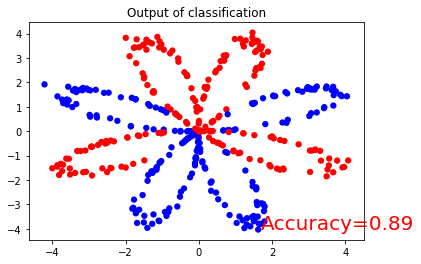

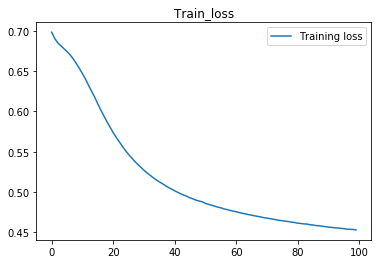

In [10]:
# 代价函数为二分类交叉熵代价函数
criterion = nn.BCELoss()
# 优化方法为Adam梯度下降方法，学习率为0.003，如果因为训练次数太少而达不到分类效果，
# 或者发现loss下降的时候震荡，可以适当调小lr
optimizer = optim.Adam(model.parameters(), lr=0.0031)
# 或者用SGD试一下
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 对训练集的全部数据学习100遍，这个数字越大，训练时间越长
# epochs = 10000
epochs = 100
# 将每次训练的训练误差和测试误差存储在这两个列表里，后面绘制误差变化折线图用
train_losses = []
print('开始训练')
for e in range(epochs):
    running_loss = 0
    # 对trainloader中每个batch的所有点进行训练，计算代价函数，反向传播优化权重，将损失求和
    for points, labels in trainloader:
        # 获得模型输出
        out = model(points)
        # 误差反向传播, 计算参数更新值
        # torch.squeeze() 这个函数主要对数据的维度进行压缩，去掉维数为1的的维度，以满足代价函数的输入格式要求
        # 比如一个一行三列（1,3）的数去掉第一个维数为一的维度之后就变成（3）行
        loss = criterion(out.squeeze(), labels)
        # 将优化器中的求导结果都设为0，否则会在每次反向传播之后叠加之前的
        optimizer.zero_grad()
        # 进行反向传播
        loss.backward()
        # 将参数更新值添加到网络的 parameters 上
        optimizer.step()
        running_loss += loss.item()
    if (e+1) % 10 == 0:
        print("epoch"+str(e+1))
#   训练完一个epoch后统计loss作图用
    train_losses.append(running_loss/len(trainloader))
# 验证画出验证的分类效果
else:
    # 预测模式
    model.eval()
    for points, labels in testloader:
        out = model(points)
        # 输出预测结果，>=0.5为class 1（蓝色），<0.5为class 0（红色）。round函数作用为四舍五入
        prediction = torch.round(out)
        pred_y = prediction.data.numpy().squeeze()
        color = []

        
########################## Question 4 ########################## 
        '''
        根据模型预测的标签绘制预测结果
        图标的绘制代码已经给出，无需补全，你只需要为不同的标签填上相对应的颜色
        要求：
        预测结果为0则绘制红色的点，预测结果为为1则绘制蓝色的点
        color.append()函数控制点的颜色，其参数为：
         'b' 蓝色
         'r' 红色
        '''
##################### Start For Your Code ##################### 
        for i in pred_y:
            if(i>=0.5):
                color.append('b')
            else:
                color.append('r')
#####################  End For Your Code  ##################### 

        target_y = labels.data.numpy()
        plt.title("Output of classification")
        plt.scatter(points.data.numpy()[:, 0], points.data.numpy()[
                    :, 1], c=color, s=40, lw=0, cmap='RdYlGn')
        accuracy = sum(pred_y == target_y)/400.  # 预测中有多少和真实值一样
        plt.text(1.7, -4, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
        plt.show()
        # 将训练误差和测试误差存在两个列表里，后面绘制误差变化折线图用
       # 恢复训练模式
        model.train()
# 绘制loss下降图（针对不同的学习速率请更改lr之后重新创建model对象，以免下一次该代码片段运行的初始化权重为上一次的结果）
plt.title("Train_loss")
plt.plot(train_losses, label='Training loss',)
plt.legend()
plt.show()

## 6.可视化分类结果

使用`model`进行验证分类效果，输出分类边界。

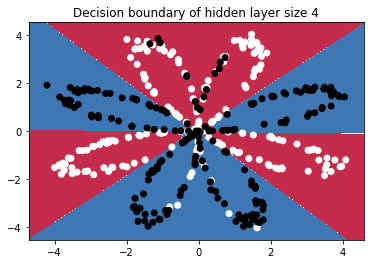

In [11]:
# 定义预测函数


def predict(pmodel, x):
    X = torch.from_numpy(x).type(torch.FloatTensor)
    ans = torch.round(pmodel(X))
    return ans.detach().numpy()


# 定义打印边界函数
def plot_decision_boundary(pred_func, X, y, hidden=4):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.title("Decision boundary of hidden layer size "+str(hidden))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)
    plt.show()

    
# 加载验证集，即原来的数据点
test_X, test_Y = load_planar_dataset()
# 可视化边界
plot_decision_boundary(lambda x: predict(model, x), test_X.T, test_Y.ravel(), hidden=4)

可以看到现在我们的数据已经被非线性分类，每一瓣花瓣都被分开了。

## 7.隐藏层的作用

隐藏层的作用就是把输入数据的特征，抽象到另一个维度空间，来展现其更抽象化的特征，这些特征能更好的进行线性划分。
例如本次课程的"花瓣"数据集。在二维平面上面无法实现线性划分，但是，当我们通过隐藏层的变换，将它映射到三维或是更高维度的空间，在某一个维度空间上，该数据集就变成了线性可分，再经过输出层的激活函数，最终达到了非线性的分类效果。

## 8.不同的隐藏层大小对分类结果的影响

**隐藏层大小（size）**即隐藏层中使用的神经元个数。

我们可以把一个神经元（感知器）的作用理解成为一种线性划分方式。

一个决策边界，一个神经元，就是线性划分；多个神经元，就是多个线性划分，而多个线性划分就是不断在逼近决策边界，可以把这个过程想象成积分过程。所以一个决策边界就是由多个线性划分组成的。对于非线性可分的数据，使用多个神经元就可以逼近其非线性的决策边界。

自然可知，如果神经元的个数很少，那么划分结果接近于线性划分，和真实的分类边界相去甚远，这就是欠拟合的情况。例如，对一个具有二次函数特征的散点图使用线性函数进行拟合，那么很多点无法很好的落在线性函数附近。

但是神经元的个数也不是越多越好。如果神经元数量很多很多，这就导致会有很多个线性划分，决策边界就越扭曲，基本上就是过拟合了。例如下面的例子展示了当隐藏层大小设置为50的时候会出现一些扭曲的边界。

换一个角度来说神经元，把它理解为学习到一种东西的物体，如果这种物体很少，就很难学到样本的特点，也就是欠拟合；如果这种物体越多，学到的东西就越来越像样本，也就是过拟合。

将隐藏层的 size 改为1，2，3，4，5，20，50分别进行模型训练，查看模型分类的边界。请你补全代码：

In [12]:
# 改变隐藏层大小再次进行训练，查看欠拟合和过拟合的情况
########################## Question 5 ##########################
'''
    要求：
    改变隐藏层的大小，观察不同大小的隐藏层对分类效果的影响。
    将隐藏层的size改为1，2，3，4，5，20，50分别进行模型训练
    将之前的训练流程封装为train_model()函数，然后通过改变参数实现不同的隐藏层大小
    此次训练完成后不需要【验证画出验证的分类效果】
    提示：
    train_model()函数的参数为 hiden_layersize
    例：train_model(hiden_layersize=10)
'''
##################### Start For Your Code #####################
def train_model(hidden_layersize=4):
        model = Classifier(2,hidden_layersize,True)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0031)
        epochs = 100
        for e in range(epochs):
            running_loss = 0
            for points, labels in trainloader:
                out = model(points)
                loss = criterion(out.squeeze(), labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        else:
            model.eval()
            for points, labels in testloader:
                out = model(points)
                prediction = torch.round(out)
                pred_y = prediction.data.numpy().squeeze()
                target_y = labels.data.numpy()
                accuracy = sum(pred_y == target_y)/400.  # 预测中有多少和真实值一样
                print('Hidden Size = '+str(hidden_layersize)+ '                  Accuracy=%.2f' % accuracy)
                model.train()
        
sett=[1,2,3,4,5,20,50]
for i in sett:
    train_model(i)
#####################  End For Your Code  #####################

Hidden Size = 1                  Accuracy=0.49
Hidden Size = 2                  Accuracy=0.66
Hidden Size = 3                  Accuracy=0.65
Hidden Size = 4                  Accuracy=0.84
Hidden Size = 5                  Accuracy=0.88
Hidden Size = 20                  Accuracy=0.89
Hidden Size = 50                  Accuracy=0.89


下面是不同size训练10000次的分类效果。可以看到，当隐藏层的数量从1增加到50时，模型分类效果由欠拟合到恰当分类再到过拟合。欠拟合情况对数据集进行线性划分，将数据集简单地划分为2类；过拟合对数据集中的一些噪声点也进行了分类，产生了很多扭曲的边界。

当隐藏层的数量小于等于2时，几乎为简单线性分类：
<img src="./output/Show_boundary1_11_30_15_12_30_.png" style="width:500px;height:350px;">
<img src="./output/Show_boundary2_11_30_15_19_08_.png" style="width:500px;height:350px;">
当隐藏层的数量为3、4、5时，分类效果较为理想，边界不易收到噪声点的影响：
<img src="./output/Show_boundary3_11_30_15_24_36_.png" style="width:500px;height:350px;">
<img src="./output/Show_boundary4_11_30_15_29_57_.png" style="width:500px;height:350px;">
<img src="./output/Show_boundary5_11_30_15_35_06_.png" style="width:500px;height:350px;">
当隐藏层的数量大于20时，模型出现过拟合现象，对数据集中的一些噪声点也进行了分类，产生了很多扭曲的边界。虽然模型几乎对所有的点都分类正确，但模型的泛化性降低，应用于其他数据集时，分类效果可能会不理想。
<img src="./output/Show_boundary20_11_30_15_43_21_.png" style="width:500px;height:350px;">
<img src="./output/Show_boundary50_11_30_15_49_14_.png" style="width:500px;height:350px;">

<span id="extra"></span>
# 八.拓展和延伸

## 1.随机梯度下降

我们在两课中使用到的都是**梯度下降**算法。

传统的梯度下降法存在局限性：每一次迭代过程需要遍历所有数据集。如果数据集无法放在内存或无法放在单个节点，则传统梯度下降法失效。

**随机梯度下降（Stochastic Gradient Descent，SGD）**是梯度下降算法的一种。不同于传统梯度下降，随机梯度下降是**每次迭代**使用**一个样本来**对参数进行更新。使得训练速度加快。

对于**一个样本**的代价函数为：

$$J^{(i)}(θ_0,θ_1)=\frac{1}{2}(h_θ(x^{(i)})−y_{(i)})^2$$

其中 $θ_0,θ_1$为要求的参数，$h_θ$ 为待拟合的函数。


对代价函数求偏导：

$$\frac{ΔJ^{(i)}(θ_0,θ_1)}{θ_j}=(h_θ(x^{(i)})−y_{(i)})x^{(i)}_j$$


参数更新：

$$θ_j:=θ_j−α(h_θ(x^{(i)})−y^{(i)})x^{(i)}_j$$

其中 $α$ 为学习率。

注意，**这里不再有求和符号**，因为每次只使用一个样本更新梯度。

## 2.代码实现

In [13]:
# 构造训练数据集
x_train = np.array(
    [[2, 0., 3], [3, 1., 3], [0, 2., 3], [4, 3., 2], [1, 4., 4]])
m = len(x_train)

x0 = np.full((m, 1), 1)

# 构造一个每个数据第一维特征都是1的矩阵
input_data = np.hstack([x0, x_train])
m, n = input_data.shape
theta1 = np.array([[2, 3, 4]]).T
# 构建标签数据集，后面的np.random.randn是将数据加一点噪声，以便模拟数据集。
#y_train = (input_data.dot(np.array([1, 2, 3, 4]).T)).T
y_train = x_train.dot(theta1) + np.array([[2], [2], [2], [2], [2]])

# 设置两个终止条件
loop_max = 1000000
epsilon = 1e-5

# 初始theta
np.random.seed(0)  # 设置随机种子
theta = np.random.randn(n, 1)   # 随机取一个1维列向量初始化theta

# 初始化步长/学习率
alpha = 0.00001
# 初始化误差，每个维度的theta都应该有一个误差，所以误差是一个4维。
error = np.zeros((n, 1))  # 列向量

# 初始化偏导数
diff = np.zeros((input_data.shape[1], 1))

# 初始化循环次数
count = 0

while count < loop_max:
    count += 1
    sum_m = np.zeros((n, 1))

    for i in range(m):
        for j in range(input_data.shape[1]):
            # 计算每个维度的theta
            diff[j] = (input_data[i].dot(theta)-y_train[i])*input_data[i, j]
        # 求每个维度的梯度的累加和
        sum_m = sum_m + diff
    # 利用这个累加和更新梯度
    theta = theta - alpha * sum_m
    # else中将前一个theta赋值给error,theta - error便表示前后两个梯度的变化，当梯度
    # 变化很小（在接收的范围内）时，便停止迭代。
    if np.linalg.norm(theta - error) < epsilon:
        break
    else:
        error = theta

print(theta)


[[2.37062254]
 [1.93597506]
 [2.88378987]
 [4.00843138]]


<span id="summary"></span>
# 九.总结

本次课程我们针对非线性可分的数据，将简单的逻辑回归模型进行改进，通过增添隐藏层的方法搭建了一个简单的全连接神经网络，实现了对"花瓣"数据集的非线性分类。在本课程中，我们学习了全连接神经网络的含义及其计算方法，学习使用pytorch深度学习框架帮助构建模型，分析隐藏层对于神经网络分类的作用，最后观察了数据集的两种常见现象——欠拟合和过拟合的情况。